In [1]:
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy as scipy
from scipy import optimize
from scipy.optimize import differential_evolution
from tqdm import tqdm

In [2]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

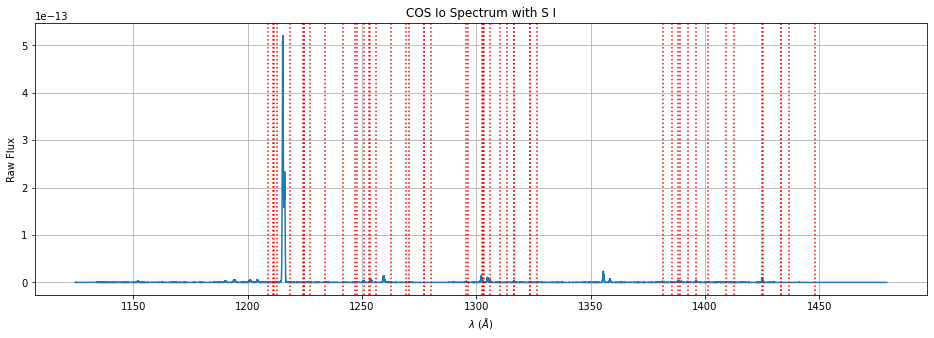

In [3]:
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum with S I")
for xc in df_wavelength:
    plt.axvline(x=xc, color = 'red', linestyle = 'dotted')
plt.grid(True) 

In [4]:
def gaussian(x, mu, sig, A):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [5]:
def double_gaussian(x, mu, sig, A, mu2, sig2, A2):
    return gaussian(x, mu, sig, A)+gaussian(x, mu2, sig2, A2)

If we want to just take neutral sulfur for now, let us do that with the code below because we only have guesses for the amplitude with neutral sulfur.

In [6]:
array = pd.read_csv('../data/least_squares_array.csv') #spaces in csv file will make df object type and not float64
array = array.loc[array['Species'].str.endswith('S I')]

In [7]:
guess = array.to_numpy()

In [8]:
wl = evt_data['WAVELENGTH'].T
flux = evt_data['FLUX'].T
wl = wl.data
flux = flux.data
wl = wl.flatten()
flux = flux.flatten()

In [9]:
#mean = sum(wl*flux)/len(wl)
#mean

In [10]:
#sigma = sum(flux*(wl-mean)**2)/len(wl)
#sigma

In [11]:
C = np.delete(guess, 1, 1)
C = C.tolist()

In [12]:
errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2
errfunc2 = lambda p, x, y: (double_gaussian(x, *p) - y)**2
x = 15 #28 is the biggest problem file, show 15 to see overlap in fit and data
guess1 = C[x]
#guess1 = [1208.84942346, 0.2, 1e-14] #manually input guess where sigma is smaller
guess2 = C[x],C[x+1]
guess1, guess2

([1253.325, 0.23, 2e-14], ([1253.325, 0.23, 2e-14], [1256.093, 0.23, 2e-14]))

In [13]:
optim1, success = optimize.leastsq(errfunc1, guess1, args=(wl, flux))
optim2, success = optimize.leastsq(errfunc2, guess2, args=(wl, flux))

In [14]:
optim1, optim2

(array([1.25352250e+03, 4.10143123e-01, 4.04892376e-15]),
 array([1.25375151e+03, 4.52163528e-01, 4.02511563e-15, 1.25609281e+03,
        2.24994729e-01, 1.31748027e-15]))

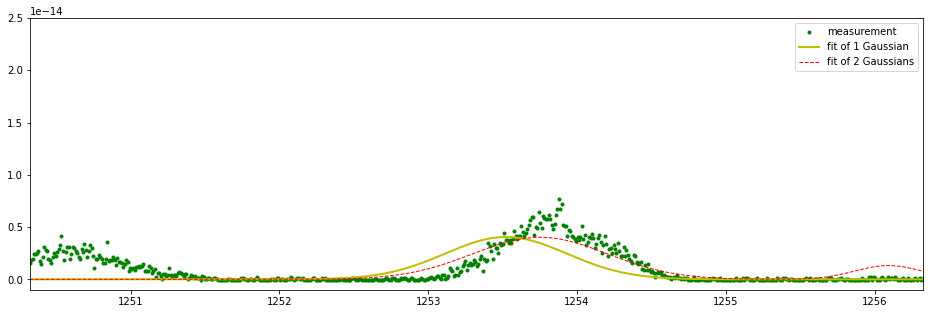

In [15]:
plt.figure(figsize=(16, 5))
plt.plot(wl, flux,'g.', label='measurement')
plt.plot(wl, gaussian(wl, *optim1),
    lw=2, c='y', label='fit of 1 Gaussian')
plt.plot(wl, double_gaussian(wl, *optim2),
    lw=1, c='r', ls='--', label='fit of 2 Gaussians')
plt.ylim(-0.01*10**-13,0.25*10**-13)
plt.xlim(guess1[0]-3,guess1[0]+3)
plt.legend(loc='best')

In [16]:
def fit_whole_spectra(array):
    params = np.zeros((len(C),3))
    for index in tqdm(range(0, len(array))):
        guess1 = C[index]
        optim1, success = optimize.leastsq(errfunc1, guess1, args=(wl, flux))
        params[index] = optim1
        #params = np.append(params,optim1,axis=0)
    return params

In [17]:
params = fit_whole_spectra(C)

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:04<00:00, 12.18it/s]


In [18]:
mu = params[:,0]
sigma = params[:,1]
amp = params[:,2]

In [24]:
mu[15], sigma[15], amp[15]

(1253.522500478284, 0.41014312284927523, 4.048923763290795e-15)

In [20]:
params[0]

array([1.20884972e+03, 2.29102962e-01, 2.61302403e-15])

In [21]:
wavelength_list = df_wavelength.values.tolist()

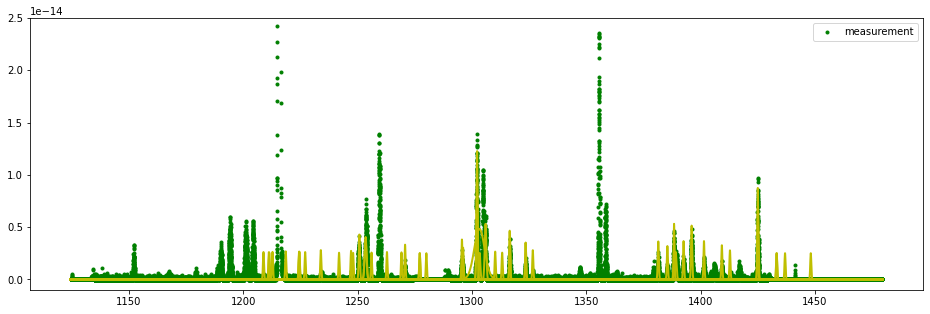

In [29]:
plt.figure(figsize=(16, 5))
plt.plot(wl, flux,'g.', label='measurement')
for index in range(0,len(params)):
    plt.plot(wl, gaussian(wl, mu[index], sigma[index], amp[index]), lw=2, c='y')
#plt.plot(wl, gaussian(wl, mu[15], sigma[15], amp[15]), lw=2, c='y', label='fit of 1 Gaussian')
plt.ylim(-0.01*10**-13,0.25*10**-13)
#plt.xlim(1252,1256)
plt.legend(loc='best')

In [ ]:
guess1 = C[1]
optim1, success = optimize.leastsq(errfunc1, guess1, args=(wl, flux))
params[1] = optim1

In [ ]:
optim1, C[1]